Разделение датасета по аномалиям\
Нужная структура: \
**[час, день недели, месяц, температура, влажность, total_AP_max]**

In [1]:
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt
from sklearn.svm import OneClassSVM

In [4]:
# wind r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/ds_electricity.csv'
# mac r'/Users/veronikalomonosova/Downloads/iqds/ds_electricity.csv'
elec = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/ds_electricity.csv')
hum = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/ds_humidity.csv')
temp = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/ds_temperature.csv')
case = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/case.csv')
equipment = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/equipment.csv')
facility = pd.read_csv(r'C:/Users/Lomonosova/Downloads/iqds.22.03/iqds/facility.csv')

c:\users\lomonosova\appdata\local\programs\python\python38\lib\site-packages\IPython\core\interactiveshell.py:3145: DtypeWarning: Columns (9,10,11,12,13,16,24,25,26,27,28,31,39,40,41,42,43,46) have mixed types.Specify dtype option on import or set low_memory=False.
  has_raised = await self.run_ast_nodes(code_ast.body, cell_name,


In [5]:
equipment

,id,io_id,weight
0,5e03a7a7832a17ee33585ecf,5e03a7a2832a17ee33585ea4,1
1,60d31a0fe7c20e0e57f9c6df,60d31a0ae7c20e0e57f9c6b8,1
2,5f33e3cbfb3bbc2c40fb6b1f,5f33e3c7fb3bbc2c40fb6afe,1
3,612ca617bdd0fcc66ed23647,612ca610bdd0fcc66ed23613,1
4,5fe8db7efec0573c471e0685,5fe8db7afec0573c471e065d,1


In [6]:
for i in case.description:
    print(i)
    print()
case

Неправильно собранное оборудование (печь) после обслуживания. 19.01.2022 – корректная работа оборудования, 20.01.2022 – повышенное энергопотребление.

Поломка обогрева вентиляции 04.10.2021. Ранние признаки поломки: 01.10.2021-03.10.2021.

Поломка вентиляции 25.11.2021 ~19:00. Сгорел ТЭН Притока, оплавились провода.

Ошибка работы вентиляции 24.11.2021, 25.11.2021, 26.11.2021. Перестало работать отключение ТЭНов.

Cгорел мотор вентиляции 28.08.2021. Сильная вибрация на моторе вентиляции 26.11.2021 (частотник сваливается в ошибку по перегрузу 26.11.2021 ~11:30, 27.11.2021 ~13:10, поменяли 2 раза мотор уже).

Вентиляция НЕ включилась (выбило автомат) 09.02.2022. Сгорел ТЭН, аналогично случаю 2!



,id,description,equipment_id,facility_id,root_facility_id
0,0,Неправильно собранное оборудование (печь) посл...,5e03a7a7832a17ee33585ecf,5e03a79d832a17ee33585e8a,5e03a79d832a17ee33585e88
1,1,Поломка обогрева вентиляции 04.10.2021. Ранние...,60d31a0fe7c20e0e57f9c6df,60d31a01e7c20e0e57f9c696,60d31a01e7c20e0e57f9c696
2,2,Поломка вентиляции 25.11.2021 ~19:00. Сгорел Т...,5f33e3cbfb3bbc2c40fb6b1f,5f33e3c1fb3bbc2c40fb6ae6,5f33e3c1fb3bbc2c40fb6ae6
3,3,"Ошибка работы вентиляции 24.11.2021, 25.11.202...",612ca617bdd0fcc66ed23647,612ca605bdd0fcc66ed235e8,612ca605bdd0fcc66ed235e8
4,4,Cгорел мотор вентиляции 28.08.2021. Сильная ви...,5fe8db7efec0573c471e0685,5fe8db72fec0573c471e0632,5fe8db72fec0573c471e0632
5,5,Вентиляция НЕ включилась (выбило автомат) 09.0...,5f33e3cbfb3bbc2c40fb6b1f,5f33e3c1fb3bbc2c40fb6ae6,5f33e3c1fb3bbc2c40fb6ae6


In [7]:
elec

,event_timestamp,io_id,Urms,Irms,P,AP_energy,RP_energy,S_energy,NP_energy,Total_P,...,S_energy_max,NP_energy_max,Total_P_max,Total_AP_energy_max,Total_RP_energy_max,Total_S_energy_max,Total_NP_energy_max,Phase_angle_max,Voltage_angle_max,Frequency_max
0,1577300188,5e03a7a2832a17ee33585ea4,"[232.31475,232.3714375,232.3470625]","[22.21553125,22.1497125,23.8967066666667]","[4667.37529411765,4913.5675,4722.21411764706]","[235.782845882353,229.163814705882,232.1835482...",[],[],[],14303.156912,...,[],[],29610.55,697.2217599999999,\N,\N,\N,[],[],\N
1,1577300308,5e03a7a2832a17ee33585ea4,"[231.673636363636,231.748727272727,231.5184545...","[27.75185,27.509425,28.0292125]","[4637.60714285714,4584.07,4693.28428571429]","[235.89653,229.27661125,232.2986025]",[],[],[],13914.961429,...,[],[],29407.98,697.51567,\N,\N,\N,[],[],\N
2,1577300489,5e03a7a2832a17ee33585ea4,"[233.040909090909,233.033818181818,232.9641818...","[20.36555,20.2714875,20.608675]","[4540.2725,4501.7025,4596.665]","[236.10616125,229.48449625,232.51070375]",[],[],[],13638.64,...,[],[],29705.48,698.1453799999999,\N,\N,\N,[],[],\N
3,1577300609,5e03a7a2832a17ee33585ea4,"[232.3894375,232.3754375,232.3269375]","[16.652875,16.587825,16.8972375]","[3883.5925,4091.60733333333,3939.47875]","[236.263205625,229.640155,232.669661875]",[],[],[],11914.678583,...,[],[],29559.86,698.66099,\N,\N,\N,[],[],\N
4,1577300729,5e03a7a2832a17ee33585ea4,"[233.157529411765,233.152058823529,233.1898235...","[15.4169058823529,15.3784,15.6478235294118]","[3348.45058823529,3314.23411764706,3398.942352...","[236.40244,229.778234117647,232.810556470588]",[],[],[],10061.627059,...,[],[],29732.67,699.07581,\N,\N,\N,[],[],\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1553813,1646092218,612ca610bdd0fcc66ed23613,"[229.473,239.143,252.404]","[0.2,0.2,0.2]","[6.93,5.77,-0.4]","[9958.99638,10177.68512,10501.09388]","[1.88205,29.90214,0.40528]",[],[],12.3,...,[],[],18.49,30637.77538,32.18947,\N,\N,"[-74.2,-81.2,-84.9]","[0,-124.5,119.3]",49.98
1553814,1646092338,612ca610bdd0fcc66ed23613,"[232.433,236.86,253.251]","[0.2,0.2,0.3]","[3.93,5.78,2.66]","[9958.99655,10177.6853,10501.09393]","[1.88205,29.90214,0.40528]",[],[],12.37,...,[],[],16.85,30637.77578,32.18947,\N,\N,"[-74.8,-81.4,-86]","[0,-124.5,118.5]",49.96
1553815,1646092458,612ca610bdd0fcc66ed23613,"[234.292,237.184,250.171]","[0.2,0.2,0.3]","[4.65,4.8,2.76]","[9958.9967,10177.68549,10501.09402]","[1.88205,29.90214,0.40528]",[],[],12.21,...,[],[],13.9,30637.77621,32.18947,\N,\N,"[-80.6,-82.5,-86]","[0,-123.3,118.8]",49.96
1553816,1646092578,612ca610bdd0fcc66ed23613,"[233.991,237.401,250.004]","[0.2,0.2,0.3]","[4.63,5.15,3.1]","[9958.99685,10177.68566,10501.09412]","[1.88205,29.90214,0.40528]",[],[],12.88,...,[],[],14.5,30637.77663,32.18947,\N,\N,"[-82,-83.2,-85.3]","[0,-123,119]",49.97


# ANOM_0
## OCSVM
532778\
OCSVM + голосование (порог, при превышении которого участок считается аномальным)\
Применить:\
- сглаживание EMD
- убрать ночь (время определить)
- добавить признаки

In [129]:
anom_0 = elec[elec.io_id == '5e03a7a2832a17ee33585ea4'].reset_index(drop=True)
anom_0.event_timestamp = pd.to_datetime(anom_0.event_timestamp, unit='s')

In [130]:
anom_0

,event_timestamp,io_id,Urms,Irms,P,AP_energy,RP_energy,S_energy,NP_energy,Total_P,...,S_energy_max,NP_energy_max,Total_P_max,Total_AP_energy_max,Total_RP_energy_max,Total_S_energy_max,Total_NP_energy_max,Phase_angle_max,Voltage_angle_max,Frequency_max
0,2019-12-25 18:56:28,5e03a7a2832a17ee33585ea4,"[232.31475,232.3714375,232.3470625]","[22.21553125,22.1497125,23.8967066666667]","[4667.37529411765,4913.5675,4722.21411764706]","[235.782845882353,229.163814705882,232.1835482...",[],[],[],14303.156912,...,[],[],29610.55,697.2217599999999,\N,\N,\N,[],[],\N
1,2019-12-25 18:58:28,5e03a7a2832a17ee33585ea4,"[231.673636363636,231.748727272727,231.5184545...","[27.75185,27.509425,28.0292125]","[4637.60714285714,4584.07,4693.28428571429]","[235.89653,229.27661125,232.2986025]",[],[],[],13914.961429,...,[],[],29407.98,697.51567,\N,\N,\N,[],[],\N
2,2019-12-25 19:01:29,5e03a7a2832a17ee33585ea4,"[233.040909090909,233.033818181818,232.9641818...","[20.36555,20.2714875,20.608675]","[4540.2725,4501.7025,4596.665]","[236.10616125,229.48449625,232.51070375]",[],[],[],13638.64,...,[],[],29705.48,698.1453799999999,\N,\N,\N,[],[],\N
3,2019-12-25 19:03:29,5e03a7a2832a17ee33585ea4,"[232.3894375,232.3754375,232.3269375]","[16.652875,16.587825,16.8972375]","[3883.5925,4091.60733333333,3939.47875]","[236.263205625,229.640155,232.669661875]",[],[],[],11914.678583,...,[],[],29559.86,698.66099,\N,\N,\N,[],[],\N
4,2019-12-25 19:05:29,5e03a7a2832a17ee33585ea4,"[233.157529411765,233.152058823529,233.1898235...","[15.4169058823529,15.3784,15.6478235294118]","[3348.45058823529,3314.23411764706,3398.942352...","[236.40244,229.778234117647,232.810556470588]",[],[],[],10061.627059,...,[],[],29732.67,699.07581,\N,\N,\N,[],[],\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561548,2022-02-28 23:50:13,5e03a7a2832a17ee33585ea4,"[232.148,232.602,232.427]","[0.2,0.1,0.1]","[9.81,-0.25,0]","[47297.01613,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.41646,44612.69163,44886.53877]","[4390.6191,725.8473,588.0761]",9.56,...,"[49011.41646,44612.69163,44886.53877]","[4390.6191,725.8473,588.0761]",9.74,133968.5065,712.8244400000001,138510.64685999998,5704.5425000000005,"[-76.9,-90.3,-89.9]","[0,-120.2,119.6]",49.98
561549,2022-02-28 23:52:13,5e03a7a2832a17ee33585ea4,"[232.384,232.618,232.325]","[0.2,0.1,0.1]","[9.75,-0.19,0]","[47297.01646,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.41783,44612.6926,44886.53976]","[4390.6191,725.8473,588.0761]",9.56,...,"[49011.41783,44612.6926,44886.53976]","[4390.6191,725.8473,588.0761]",9.75,133968.50683,712.8244400000001,138510.65019000001,5704.5425000000005,"[-76.9,-90.3,-90]","[0,-120.2,119.6]",49.97
561550,2022-02-28 23:54:13,5e03a7a2832a17ee33585ea4,"[232.084,232.277,232.329]","[0.2,0.1,0.1]","[8.56,0,0.06]","[47297.01678,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.41922,44612.69358,44886.54076]","[4390.6191,725.8473,588.0761]",8.62,...,"[49011.41922,44612.69358,44886.54076]","[4390.6191,725.8473,588.0761]",10.01,133968.50715,712.8244400000001,138510.65356,5704.5425000000005,"[-77,-90.1,-89.8]","[0,-120.2,119.6]",49.96
561551,2022-02-28 23:56:13,5e03a7a2832a17ee33585ea4,"[232.215,232.449,232.48]","[0.2,0.1,0.1]","[10.31,-0.19,0]","[47297.01711,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.42057,44612.69454,44886.54173]","[4390.6191,725.8473,588.0761]",10.12,...,"[49011.42057,44612.69454,44886.54173]","[4390.6191,725.8473,588.0761]",10.82,133968.50748,712.8244400000001,138510.65684,5704.5425000000005,"[-75.9,-90.1,-89.7]","[0,-120.1,119.7]",49.96


In [131]:
delta_seconds = anom_0.event_timestamp.diff() / np.timedelta64(1, 's')
delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
delta_seconds = delta_seconds[1:]

AP = anom_0['Total_AP_energy_max']
#print(len(AP), len())
a = []
for j, i in enumerate(anom_0['Total_AP_energy_max']):
    try:
        i = float(i)
    except ValueError:
        a.append(j)
for i in a:
    AP[i] = AP[i - 1]
    
AP = np.diff(np.array(AP, dtype = float)) * 1000
X = AP/delta_seconds

<ipython-input-131-731a233aa687>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AP[i] = AP[i - 1]


In [11]:
el1 = X[90:3090] 
el2 = X[22289:25289]
el3 = X[42270:45270]

el4 = X[64471:67471] 
el5 = X[83059:86059]
el6 = X[103413:106413]

el7 = X[124943:127943] 
el8 = X[146959:149959]
el9 = X[172823:175823]

el10 = X[191337:194337] 
el11 = X[213579:216579]
el12 = X[238118:241118]

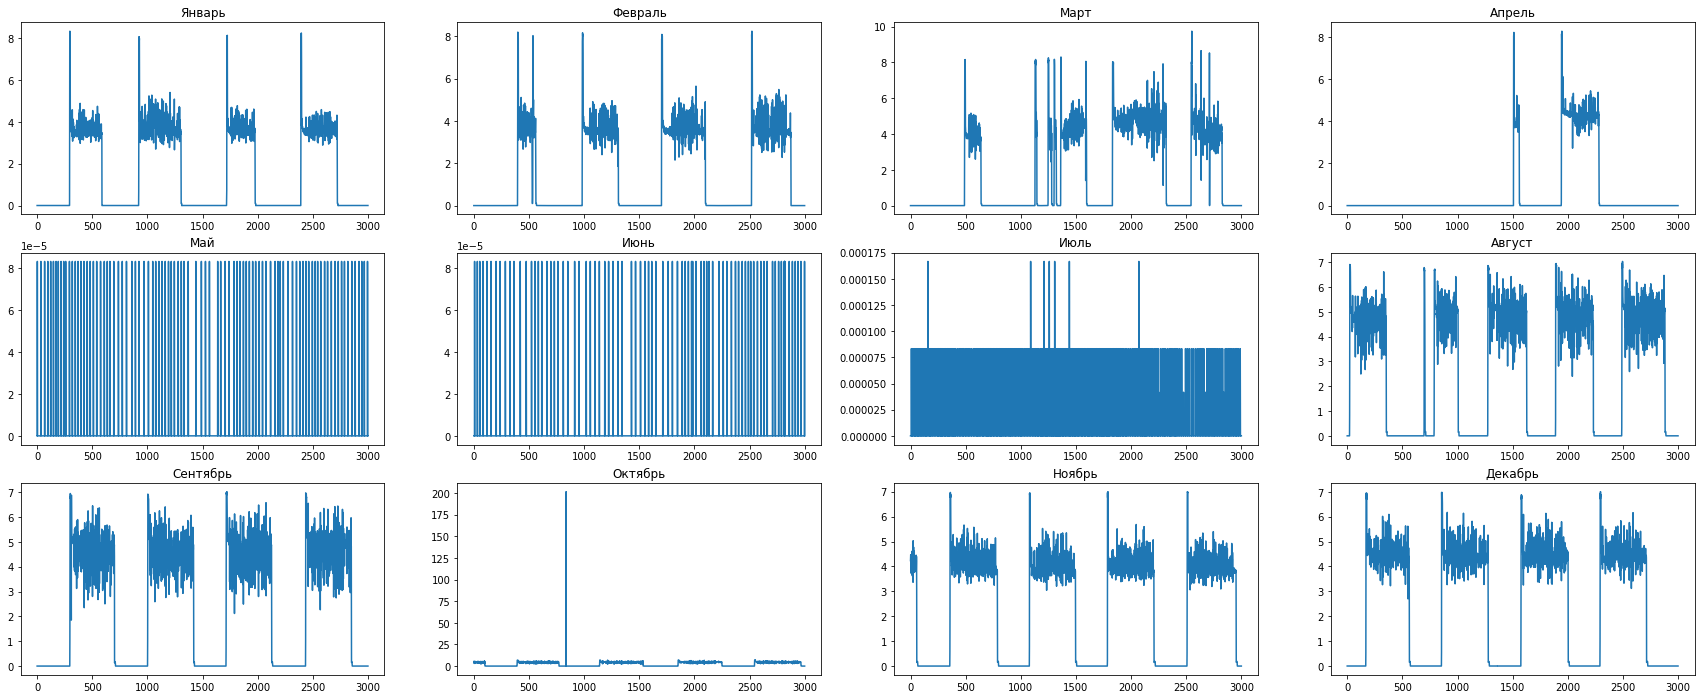

In [12]:
y = np.arange(0, 3000)
plt.figure(figsize=(30,12))
plt.subplot(3, 4, 1)
plt.title('Январь')
plt.plot(y, el1)  
plt.subplot(3, 4, 2)
plt.title('Февраль')
plt.plot(y, el2)
plt.subplot(3, 4, 3)
plt.title('Март')
plt.plot(y, el3)

plt.subplot(3, 4, 4)
plt.title('Апрель')
plt.plot(y, el4)
plt.subplot(3, 4, 5)
plt.title('Май')
plt.plot(y, el5)
plt.subplot(3, 4, 6)
plt.title('Июнь')
plt.plot(y, el6)

plt.subplot(3, 4, 7)
plt.title('Июль')
plt.plot(y, el7)
plt.subplot(3, 4, 8)
plt.title('Август')
plt.plot(y, el8)
plt.subplot(3, 4, 9)
plt.title('Сентябрь')
plt.plot(y, el9)

plt.subplot(3, 4, 10)
plt.title('Октябрь')
plt.plot(y, el10)
plt.subplot(3, 4, 11)
plt.title('Ноябрь')
plt.plot(y, el11)
plt.subplot(3, 4, 12)
plt.title('Декабрь')
plt.plot(y, el12)

In [13]:
anom_0

,event_timestamp,io_id,Urms,Irms,P,AP_energy,RP_energy,S_energy,NP_energy,Total_P,...,S_energy_max,NP_energy_max,Total_P_max,Total_AP_energy_max,Total_RP_energy_max,Total_S_energy_max,Total_NP_energy_max,Phase_angle_max,Voltage_angle_max,Frequency_max
0,2019-12-25 18:56:28,5e03a7a2832a17ee33585ea4,"[232.31475,232.3714375,232.3470625]","[22.21553125,22.1497125,23.8967066666667]","[4667.37529411765,4913.5675,4722.21411764706]","[235.782845882353,229.163814705882,232.1835482...",[],[],[],14303.156912,...,[],[],29610.55,697.2217599999999,\N,\N,\N,[],[],\N
1,2019-12-25 18:58:28,5e03a7a2832a17ee33585ea4,"[231.673636363636,231.748727272727,231.5184545...","[27.75185,27.509425,28.0292125]","[4637.60714285714,4584.07,4693.28428571429]","[235.89653,229.27661125,232.2986025]",[],[],[],13914.961429,...,[],[],29407.98,697.51567,\N,\N,\N,[],[],\N
2,2019-12-25 19:01:29,5e03a7a2832a17ee33585ea4,"[233.040909090909,233.033818181818,232.9641818...","[20.36555,20.2714875,20.608675]","[4540.2725,4501.7025,4596.665]","[236.10616125,229.48449625,232.51070375]",[],[],[],13638.64,...,[],[],29705.48,698.1453799999999,\N,\N,\N,[],[],\N
3,2019-12-25 19:03:29,5e03a7a2832a17ee33585ea4,"[232.3894375,232.3754375,232.3269375]","[16.652875,16.587825,16.8972375]","[3883.5925,4091.60733333333,3939.47875]","[236.263205625,229.640155,232.669661875]",[],[],[],11914.678583,...,[],[],29559.86,698.66099,\N,\N,\N,[],[],\N
4,2019-12-25 19:05:29,5e03a7a2832a17ee33585ea4,"[233.157529411765,233.152058823529,233.1898235...","[15.4169058823529,15.3784,15.6478235294118]","[3348.45058823529,3314.23411764706,3398.942352...","[236.40244,229.778234117647,232.810556470588]",[],[],[],10061.627059,...,[],[],29732.67,699.07581,\N,\N,\N,[],[],\N
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
561548,2022-02-28 23:50:13,5e03a7a2832a17ee33585ea4,"[232.148,232.602,232.427]","[0.2,0.1,0.1]","[9.81,-0.25,0]","[47297.01613,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.41646,44612.69163,44886.53877]","[4390.6191,725.8473,588.0761]",9.56,...,"[49011.41646,44612.69163,44886.53877]","[4390.6191,725.8473,588.0761]",9.74,133968.5065,712.8244400000001,138510.64685999998,5704.5425000000005,"[-76.9,-90.3,-89.9]","[0,-120.2,119.6]",49.98
561549,2022-02-28 23:52:13,5e03a7a2832a17ee33585ea4,"[232.384,232.618,232.325]","[0.2,0.1,0.1]","[9.75,-0.19,0]","[47297.01646,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.41783,44612.6926,44886.53976]","[4390.6191,725.8473,588.0761]",9.56,...,"[49011.41783,44612.6926,44886.53976]","[4390.6191,725.8473,588.0761]",9.75,133968.50683,712.8244400000001,138510.65019000001,5704.5425000000005,"[-76.9,-90.3,-90]","[0,-120.2,119.6]",49.97
561550,2022-02-28 23:54:13,5e03a7a2832a17ee33585ea4,"[232.084,232.277,232.329]","[0.2,0.1,0.1]","[8.56,0,0.06]","[47297.01678,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.41922,44612.69358,44886.54076]","[4390.6191,725.8473,588.0761]",8.62,...,"[49011.41922,44612.69358,44886.54076]","[4390.6191,725.8473,588.0761]",10.01,133968.50715,712.8244400000001,138510.65356,5704.5425000000005,"[-77,-90.1,-89.8]","[0,-120.2,119.6]",49.96
561551,2022-02-28 23:56:13,5e03a7a2832a17ee33585ea4,"[232.215,232.449,232.48]","[0.2,0.1,0.1]","[10.31,-0.19,0]","[47297.01711,43179.84733,43491.64304]","[353.81777,166.19428,192.81239]","[49011.42057,44612.69454,44886.54173]","[4390.6191,725.8473,588.0761]",10.12,...,"[49011.42057,44612.69454,44886.54173]","[4390.6191,725.8473,588.0761]",10.82,133968.50748,712.8244400000001,138510.65684,5704.5425000000005,"[-75.9,-90.1,-89.7]","[0,-120.1,119.7]",49.96


In [14]:
for i in range(len(anom_0)):
    if '2022-01-20' in str(anom_0.event_timestamp[i]):
        print('ANOM INDEX: ', i)
        break

ANOM INDEX:  532778


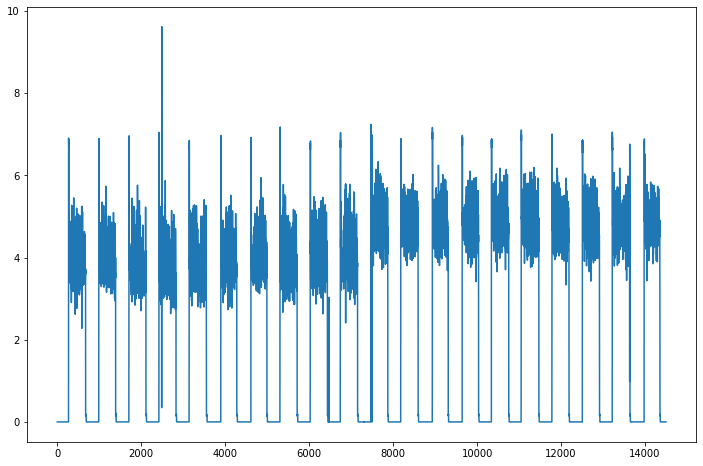

In [103]:
el1 = X[532778 - 730 * 10:532778 + 720 * 10] 
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(el1)), el1)

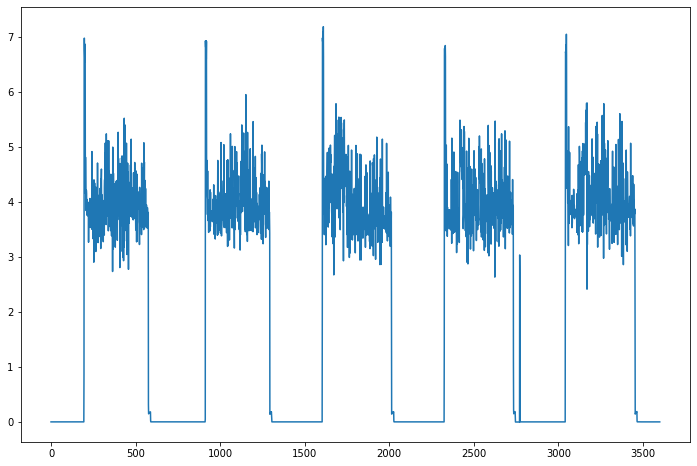

In [76]:
train = np.array(X[532778 - 720*5:532778])[:, np.newaxis]
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(train)), train)

In [77]:
nu = 0.05  # theory says it should be an upper bound of the fraction of outliers
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
ocsvm.fit(train)
preds = ocsvm.predict(train)

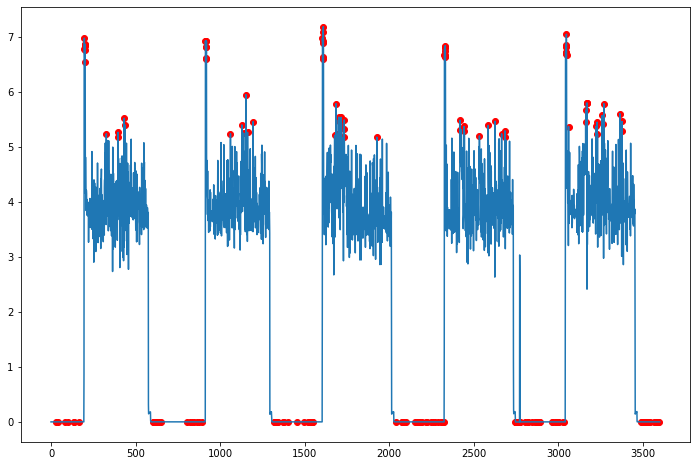

In [79]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train)), train)
plt.scatter(np.where(preds == -1)[0], train[np.where(preds == -1)[0]], color='red')

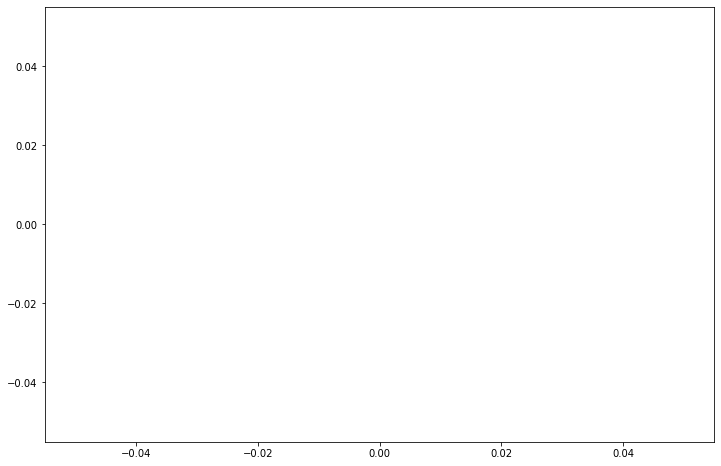

In [97]:
test = np.array(X[532778 - 720*10:532778 + 720 * 1])[:, np.newaxis]
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(test)), test)

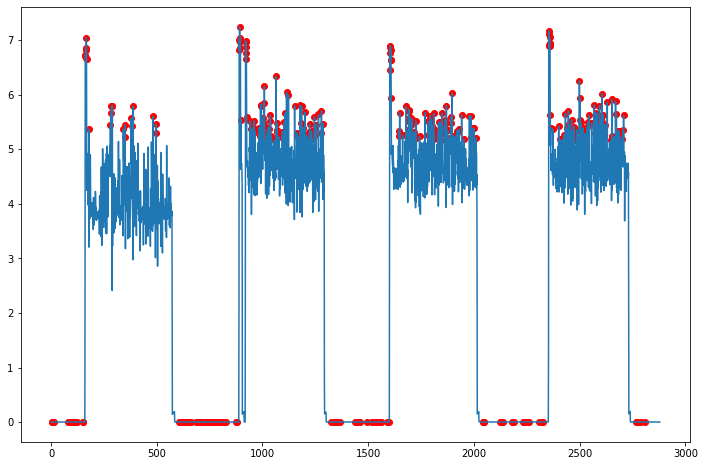

In [81]:
preds = ocsvm.predict(test)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(test)), test)
plt.scatter(np.where(preds == -1)[0], test[np.where(preds == -1)[0]], color='red')

In [18]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(X)), X)
for i in range(len(preds)):
    if preds[i] != 1:
        plt.scatter(i, X[i], color='red')

KeyboardInterrupt: 

Error in callback <function flush_figures at 0x0000025A0D906A60> (for post_execute):


KeyboardInterrupt: 

In [ ]:
params = [0.005, 0.05, 0.5, 0.7, 0.9]
fig, ax = plt.subplots(figsize=(12, 625), nrows=len(params) * len(params) * 4, ncols=1)
k = -1
r = -1
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    k += 1
    #r = -1
    for nu in params:
        for gamma in params:
            r += 1
            ocsvm = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
            ocsvm.fit(X)
            preds = ocsvm.predict(X)
            ax[r].plot(np.arange(len(X)), X)
            for i in range(len(preds)):
                if preds[i] != 1:
                    ax[r].scatter(i, X[i], color='red')
            ax[r].set_title(f'Kernel {kernel}, gamma {gamma}, nu {nu}')

In [ ]:
params = [0.05, 0.5]#, 0.7, 0.9]
fig, ax = plt.subplots(figsize=(12, 100), nrows=len(params) * len(params) * 4, ncols=1)
k = -1
r = -1
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    k += 1
    #r = -1
    for nu in params:
        for gamma in params:
            r += 1
            ocsvm = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
            ocsvm.fit(X)
            preds = ocsvm.predict(X)
            ax[r].plot(np.arange(len(X)), X)
            for i in range(len(preds)):
                if preds[i] != 1:
                    ax[r].scatter(i, X[i], color='red')
            ax[r].set_title(f'Kernel {kernel}, gamma {gamma}, nu {nu}')

In [188]:
#anom_0['X'] = X
days = anom_0.loc[532778 - 720*10:532778 + 720 * 0].reset_index(drop=True)
days = days[(days.event_timestamp.apply(datetime.time) < datetime.strptime('19:00:00', '%H:%M:%S').time()) & \
             (days.event_timestamp.apply(datetime.time) > datetime.strptime('6:40:00', '%H:%M:%S').time())].reset_index(drop=True)

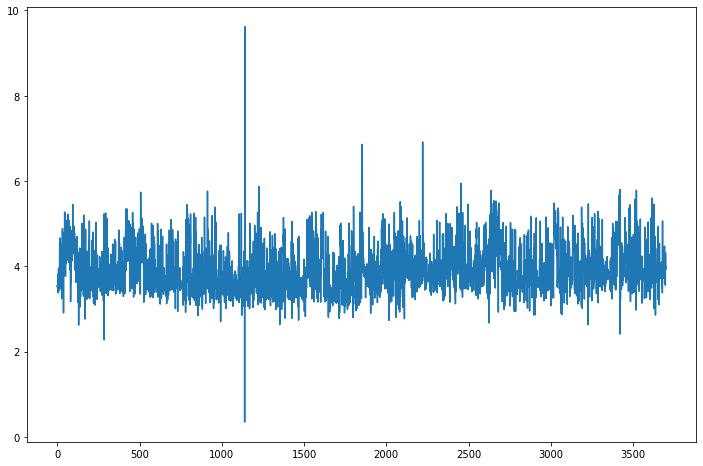

In [189]:
plt.figure(figsize=(12, 8))
el = days.X
plt.plot(np.arange(len(el)), el)

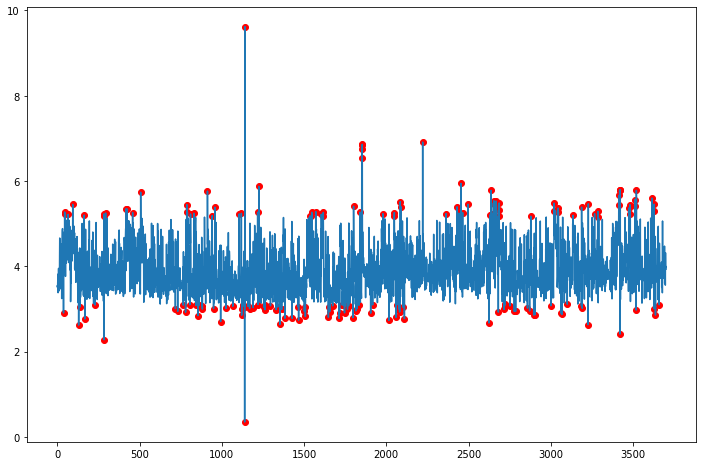

In [190]:
train = np.array(days.X)[:, np.newaxis]
nu = 0.05  # theory says it should be an upper bound of the fraction of outliers
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
ocsvm.fit(train)
preds = ocsvm.predict(train)
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(train)), train)
plt.scatter(np.where(preds == -1)[0], train[np.where(preds == -1)[0]], color='red')

In [146]:
days[['event_timestamp', 'X']]

,event_timestamp,X
0,2022-01-10 07:00:45,3.649333
1,2022-01-10 07:02:45,3.489083
2,2022-01-10 07:04:45,3.442500
3,2022-01-10 07:06:45,3.578667
4,2022-01-10 07:08:45,4.032583
...,...,...
3956,2022-01-20 18:51:54,4.760417
3957,2022-01-20 18:53:54,4.514167
3958,2022-01-20 18:55:54,4.078833
3959,2022-01-20 18:57:54,5.469083


In [89]:
# дропаем ночное время
anom_0.event_timestamp.apply(datetime.time) > datetime.strptime('19:05:00', '%H:%M:%S').time() 

0         False
1         False
2         False
3         False
4          True
          ...  
561548     True
561549     True
561550     True
561551     True
561552     True
Name: event_timestamp, Length: 561553, dtype: bool

In [88]:
anom_0.event_timestamp.apply(datetime.time)

0         18:56:28
1         18:58:28
2         19:01:29
3         19:03:29
4         19:05:29
            ...   
561548    23:50:13
561549    23:52:13
561550    23:54:13
561551    23:56:13
561552    23:58:13
Name: event_timestamp, Length: 561553, dtype: object

# ANOM_1
## OCSVM
71905

In [68]:
anom_1 = elec[elec.io_id == '60d31a0ae7c20e0e57f9c6b8'].reset_index(drop=True)
anom_1.event_timestamp = pd.to_datetime(anom_1.event_timestamp, unit='s')

In [ ]:
delta_seconds = anom_1.event_timestamp.diff() / np.timedelta64(1, 's')
delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
delta_seconds = delta_seconds[1:]

AP = anom_1['Total_AP_energy_max']
#print(len(AP), len())
a = []
for j, i in enumerate(anom_1['Total_AP_energy_max']):
    try:
        i = float(i)
    except ValueError:
        a.append(j)
for i in a:
    AP[i] = AP[i - 1]
    
AP = np.diff(np.array(AP, dtype = float)) * 1000
X = AP/delta_seconds

In [ ]:
el1 = X[90:3090] 
el2 = X[22289:25289]
el3 = X[42270:45270]

el4 = X[64471:67471] 
el5 = X[83059:86059]
el6 = X[103413:106413]

el7 = X[124943:127943] 
el8 = X[146959:149959]
el9 = X[172823:175823]

el10 = X[191337:194337] 
el11 = X[213579:216579]
el12 = X[238118:241118]

In [ ]:
y = np.arange(0, 3000)
plt.figure(figsize=(30,12))
plt.subplot(3, 4, 1)
plt.title('Январь')
plt.plot(y, el1)  
plt.subplot(3, 4, 2)
plt.title('Февраль')
plt.plot(y, el2)
plt.subplot(3, 4, 3)
plt.title('Март')
plt.plot(y, el3)

plt.subplot(3, 4, 4)
plt.title('Апрель')
plt.plot(y, el4)
plt.subplot(3, 4, 5)
plt.title('Май')
plt.plot(y, el5)
plt.subplot(3, 4, 6)
plt.title('Июнь')
plt.plot(y, el6)

plt.subplot(3, 4, 7)
plt.title('Июль')
plt.plot(y, el7)
plt.subplot(3, 4, 8)
plt.title('Август')
plt.plot(y, el8)
plt.subplot(3, 4, 9)
plt.title('Сентябрь')
plt.plot(y, el9)

plt.subplot(3, 4, 10)
plt.title('Октябрь')
plt.plot(y, el10)
plt.subplot(3, 4, 11)
plt.title('Ноябрь')
plt.plot(y, el11)
plt.subplot(3, 4, 12)
plt.title('Декабрь')
plt.plot(y, el12)

In [ ]:
for i in range(len(anom_1)):
    if '2021-10-01' in str(anom_1.event_timestamp[i]):
        print('ANOM INDEX: ', i)
        break

In [ ]:
k = 3
el1 = X[71905 - 730 * 1:71905 + 720 * 4] 
plt.figure(figsize=(20, 8))
plt.plot(np.arange(len(el1)), el1)
plt.scatter(730 * k, 4, color='red')

In [ ]:
X = np.array(X)[:, np.newaxis]
X = X[71905 - 730 :71905 + 720 * 4] 

In [ ]:
params = [0.005, 0.05, 0.5, 0.7, 0.9]
fig, ax = plt.subplots(figsize=(12, 625), nrows=len(params) * len(params) * 4, ncols=1)
k = -1
r = -1
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    k += 1
    #r = -1
    for nu in params:
        for gamma in params:
            r += 1
            ocsvm = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
            ocsvm.fit(X)
            preds = ocsvm.predict(X)
            ax[r].plot(np.arange(len(X)), X)
            for i in range(len(preds)):
                if preds[i] != 1:
                    ax[r].scatter(i, X[i], color='red')
            ax[r].set_title(f'Kernel {kernel}, gamma {gamma}, nu {nu}')

# ANOM 2
335773

In [19]:
anom_2 = elec[elec.io_id == '5f33e3c7fb3bbc2c40fb6afe'].reset_index(drop=True)
anom_2.event_timestamp = pd.to_datetime(anom_2.event_timestamp, unit='s')

In [21]:
delta_seconds = anom_2.event_timestamp.diff() / np.timedelta64(1, 's')
delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
delta_seconds = delta_seconds[1:]

AP = anom_2['Total_AP_energy_max']
#print(len(AP), len())
a = []
for j, i in enumerate(anom_2['Total_AP_energy_max']):
    try:
        i = float(i)
    except ValueError:
        a.append(j)
for i in a:
    AP[i] = AP[i - 1]
    
AP = np.diff(np.array(AP, dtype = float)) * 1000
X = AP/delta_seconds

<ipython-input-21-5d0392c56d58>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AP[i] = AP[i - 1]


In [22]:
for i in range(len(anom_2)):
    if '2021-11-25' in str(anom_2.event_timestamp[i]):
        print('ANOM INDEX: ', i)
        break

ANOM INDEX:  335773


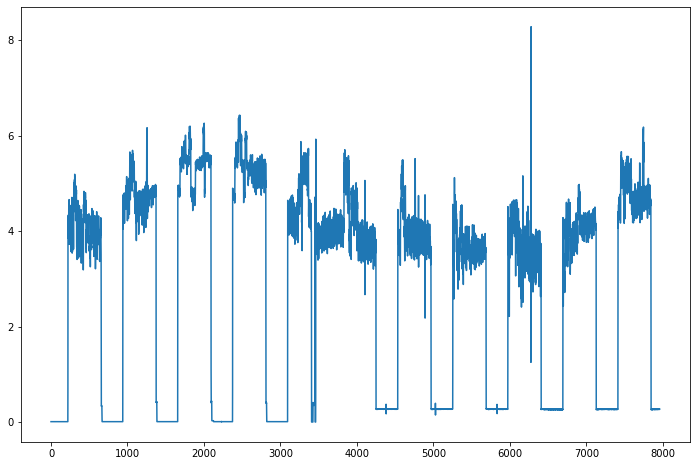

In [31]:
el1 = X[335773 - 730 * 4:335773 + 720 * 7] 
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(el1)), el1)

In [41]:
el1 = np.array(X[335773 - 730 * 4:335773 + 720 * 7] )[:, np.newaxis]

nu = 0.05  # theory says it should be an upper bound of the fraction of outliers
ocsvm = OneClassSVM(kernel='rbf', gamma=0.05, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
ocsvm.fit(el1)
preds = ocsvm.predict(el1)

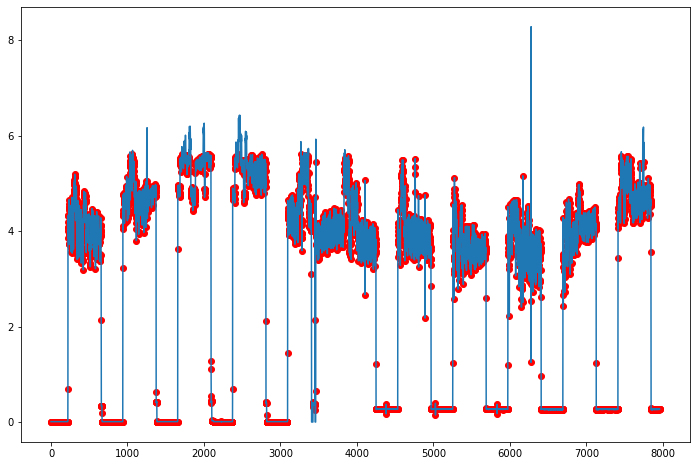

In [42]:
plt.figure(figsize=(12, 8))
plt.plot(np.arange(len(el1)), el1)
plt.scatter(np.where(preds != -1)[0], el1[np.where(preds != -1)[0]], color='red')


In [ ]:
X = el1

params = [0.005, 0.05, 0.5, 0.7, 0.9]
fig, ax = plt.subplots(figsize=(12, 625), nrows=len(params) * len(params) * 4, ncols=1)
k = -1
r = -1
for kernel in ['linear', 'poly', 'rbf', 'sigmoid']:
    k += 1
    #r = -1
    for nu in params:
        for gamma in params:
            r += 1
            ocsvm = OneClassSVM(kernel=kernel, gamma=gamma, nu=nu) # {‘linear’, ‘poly’, ‘rbf’, ‘sigmoid’, ‘precomputed’}
            ocsvm.fit(X)
            preds = ocsvm.predict(X)
            ax[r].plot(np.arange(len(X)), X)
            for i in range(len(preds)):
                if preds[i] != 1:
                    ax[r].scatter(i, X[i], color='red')
            ax[r].set_title(f'Kernel {kernel}, gamma {gamma}, nu {nu}')

# ANOM 3
## ????????????
40842

In [43]:
anom_3 = elec[elec.io_id == '612ca610bdd0fcc66ed23613'].reset_index(drop=True)
anom_3.event_timestamp = pd.to_datetime(anom_3.event_timestamp, unit='s')

In [44]:
delta_seconds = anom_3.event_timestamp.diff() / np.timedelta64(1, 's')
delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
delta_seconds = delta_seconds[1:]

AP = anom_3['Total_AP_energy_max']
#print(len(AP), len())
a = []
for j, i in enumerate(anom_3['Total_AP_energy_max']):
    try:
        i = float(i)
    except ValueError:
        a.append(j)
for i in a:
    AP[i] = AP[i - 1]
    
AP = np.diff(np.array(AP, dtype = float)) * 1000
X = AP/delta_seconds

<ipython-input-44-44035aeb5eca>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AP[i] = AP[i - 1]


In [45]:
for i in range(len(anom_3)):
    if '2021-11-24' in str(anom_3.event_timestamp[i]):
        print('ANOM INDEX: ', i)
        break

ANOM INDEX:  40842


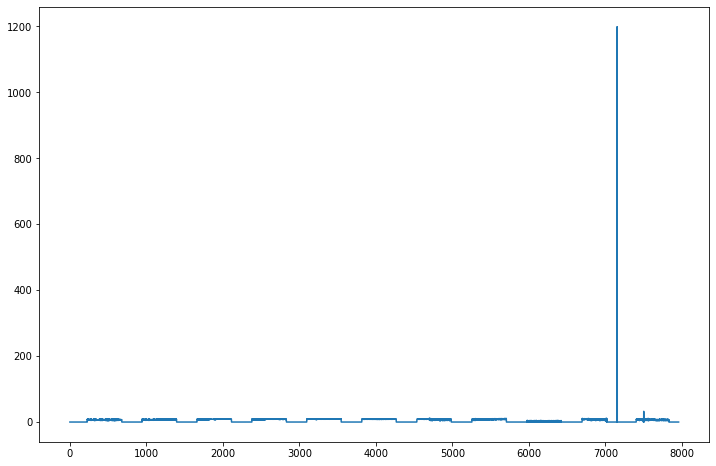

In [50]:
el1 = X[40842 - 730 * 4:40842 + 720 * 7] 
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(el1)), el1)

# ANOM 4
164019

In [53]:
anom_4 = elec[elec.io_id == '5fe8db7afec0573c471e065d'].reset_index(drop=True)
anom_4.event_timestamp = pd.to_datetime(anom_4.event_timestamp, unit='s')

In [54]:
delta_seconds = anom_4.event_timestamp.diff() / np.timedelta64(1, 's')
delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
delta_seconds = delta_seconds[1:]

AP = anom_4['Total_AP_energy_max']
#print(len(AP), len())
a = []
for j, i in enumerate(anom_4['Total_AP_energy_max']):
    try:
        i = float(i)
    except ValueError:
        a.append(j)
for i in a:
    AP[i] = AP[i - 1]
    
AP = np.diff(np.array(AP, dtype = float)) * 1000
X = AP/delta_seconds

<ipython-input-54-b563c21a8a90>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AP[i] = AP[i - 1]


In [55]:
for i in range(len(anom_3)):
    if '2021-08-28' in str(anom_3.event_timestamp[i]):
        print('ANOM INDEX: ', i)
        break

ANOM INDEX:  164019


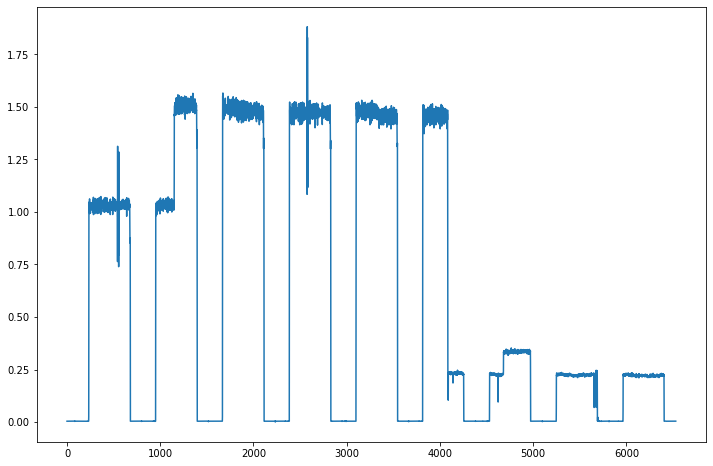

In [61]:
el1 = X[164019 - 730 * 5:164019 + 720 * 4] 
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(el1)), el1)

# ANOM 5
390482

In [62]:
anom_5 = elec[elec.io_id == '5f33e3c7fb3bbc2c40fb6afe'].reset_index(drop=True)
anom_5.event_timestamp = pd.to_datetime(anom_5.event_timestamp, unit='s')

In [63]:
delta_seconds = anom_5.event_timestamp.diff() / np.timedelta64(1, 's')
delta_seconds[np.where(delta_seconds == 0)[0]] = 1e-3
delta_seconds = delta_seconds[1:]

AP = anom_5['Total_AP_energy_max']
#print(len(AP), len())
a = []
for j, i in enumerate(anom_5['Total_AP_energy_max']):
    try:
        i = float(i)
    except ValueError:
        a.append(j)
for i in a:
    AP[i] = AP[i - 1]
    
AP = np.diff(np.array(AP, dtype = float)) * 1000
X = AP/delta_seconds

<ipython-input-63-365817e26b6a>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  AP[i] = AP[i - 1]


In [65]:
for i in range(len(anom_5)):
    if '2022-02-09' in str(anom_5.event_timestamp[i]):
        print('ANOM INDEX: ', i)
        break

ANOM INDEX:  390482


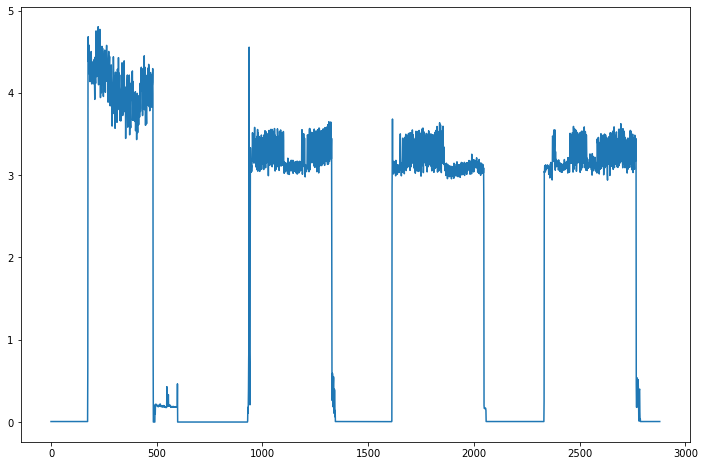

In [67]:
el1 = X[390482:390482 + 720 * 4] 
plt.figure(figsize=(12,8))
plt.plot(np.arange(len(el1)), el1)